In [1]:
from functools import partial
# import keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, GlobalMaxPool1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, Activation, concatenate, SpatialDropout1D, TimeDistributed, Layer, AlphaDropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
from tensorflow.image import extract_patches
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from functools import partial
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score
import sklearn
from sklearn.metrics import confusion_matrix

# Statistics Libraries
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind,ttest_rel, mannwhitneyu

# Clustering Code
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# General Libraries
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
import h5py
import os

# Visualization Libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors


2024-03-15 22:29:45.724595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Import Data

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

folderpath = '/data/users3/cellis42/Spectral_Explainability/PreTraining/Data/'
filepath = [folderpath + 'segmented_hc1_data_like_sleep.npy',
            folderpath + 'segmented_hc2_data_like_sleep.npy',
            folderpath + 'segmented_mdd1_data_like_sleep.npy',
            folderpath + 'segmented_mdd2_data_like_sleep.npy']

for i in np.arange(4):

    f = np.load(filepath[i],allow_pickle=True).item()
    
    if i == 0:
        data = f['data']
        labels = f['label']
        groups = f['subject']
    else:
        data = np.concatenate((data,f['data']),axis=0)
        labels = np.concatenate((labels,f['label']),axis=0)
        groups = np.concatenate((groups,f['subject']),axis=0)
        channels = f['channels']
                
channels2 = []
for i in range(19):
    channels2.append(channels[i].strip('EEG ').strip('-L'))

channels = channels2
channels2 = []

data = np.swapaxes(data,1,2)
# data = np.expand_dims(data,axis=3)

2024-03-15 00:16:45.816171: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-15 00:16:45.819499: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-15 00:16:45.940505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2024-03-15 00:16:45.940564: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-15 00:16:46.073306: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-15 00:16:46.073481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Num GPUs Available:  1


## Define Optimal Architectures

In [2]:
def get_Model_M2():

    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                    kernel_constraint=max_norm(max_value = 1))

    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    inputs = Input(shape=(n_timesteps, n_features))

    x = tf.transpose(inputs,perm=[0,2,1])

    stride_kernel_size_0 = 50
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters = 20,
                    kernel_size = stride_kernel_size_0, 
                    strides = stride_kernel_size_0,
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    x = tf.transpose(x,perm=[0,1,3,2])
    x = BatchNormalization()(x)

    stride_size_1 = 10
    kernel_size_1 = 10
    x = convLayer2D(filters=1,
                    kernel_size= (kernel_size_1,1), 
                    strides=(stride_size_1,1),
                    data_format='channels_last')(x)
    x = tf.squeeze(x,axis=3)
    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Dense(12,activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    outputs = Dense(2,activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = 0.001#hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

In [3]:
def get_Model_M3():

    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                    kernel_constraint=max_norm(max_value = 1))

    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    inputs = Input(shape=(n_timesteps, n_features))

    x = tf.transpose(inputs,perm=[0,2,1])

    stride_kernel_size_0 = 50
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters = 20,
                    kernel_size = stride_kernel_size_0, 
                    strides = stride_kernel_size_0,
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    x = tf.transpose(x,perm=[0,1,3,2])
    x = BatchNormalization()(x)

    stride_size_1 = 10
    kernel_size_1 = 5
    x = convLayer2D(filters=1,
                    kernel_size= (kernel_size_1,1), 
                    strides=(stride_size_1,1),
                    data_format='channels_last')(x)
    x = tf.squeeze(x,axis=3)
    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.1)(x)
    outputs = Dense(2,activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

# M2 - Assign Filters to Clusters

In [4]:
def cluster_samples(data):
    kcluster = KMeans(n_clusters=3,n_init = 100, random_state=0).fit(data)
    Y_pred = np.transpose(kcluster.labels_)
    cluster_centers = kcluster.cluster_centers_
            
    return(Y_pred,cluster_centers)

In [5]:
from scipy.fft import fft, fftfreq

In [6]:
power_n_all_M2 = [];
all_weights_M2 = [];
all_weights_fold_M2 = []; all_weights_fold_idx_M2 = [];

for i in range(50):
    file_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M2v3_kt_fold0" + str(i) + ".hdf5"
    model = get_Model_M2();
    model.load_weights(file_path);
    
    filt_len_M2 = 50
    n_filters_m2 = 20

    weights_M2 = np.squeeze(model.layers[3].get_weights()[0]);
    all_weights_M2.extend(weights_M2)
    
    # Get Spectral Power
    power_M2 = (2.0/filt_len_M2) * np.absolute(fft(weights_M2.T,axis=1))[:,0:filt_len_M2//2]
    freq_vals_M2 = fftfreq(filt_len_M2,0.01)[0:filt_len_M2//2]
    power_n_M2 = (power_M2-np.min(power_M2,axis=0))/(np.max(power_M2,axis=0)-np.min(power_M2,axis=0))
    power_n_all_M2.extend(power_n_M2)
    all_weights_fold_M2.extend(i*np.ones(n_filters_m2,))
    all_weights_fold_idx_M2.extend(np.arange(n_filters_m2))

2024-03-15 22:30:01.939333: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-15 22:30:01.942451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-15 22:30:02.038569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2024-03-15 22:30:02.038628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-15 22:30:02.155726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-15 22:30:02.155833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

In [7]:
cluster_labels_M2,centers_M2 = cluster_samples(np.array(power_n_all_M2)[:,1:])
NClusters = len(np.unique(cluster_labels_M2))

# M3 - Assign Filters to Clusters

In [8]:
power_n_all_M3 = [];
all_weights_M3 = [];
all_weights_fold_M3 = []; all_weights_fold_idx_M3 = [];
for i in range(50):
    file_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M3_XAIWC_kt_fold0" + str(i) + ".hdf5"
    model = get_Model_M3();
    model.load_weights(file_path);
    
    filt_len_M3 = 50
    n_filters_m3 = 20

    weights_M3 = np.squeeze(model.layers[3].get_weights()[0]);
    all_weights_M3.extend(weights_M3)
    
    # Get Spectral Power
    power_M3 = (2.0/filt_len_M3) * np.absolute(fft(weights_M3.T,axis=1))[:,0:filt_len_M3//2]
    freq_vals_M3 = fftfreq(filt_len_M3,0.01)[0:filt_len_M3//2]
    power_n_M3 = (power_M3-np.min(power_M3,axis=0))/(np.max(power_M3,axis=0)-np.min(power_M3,axis=0))
    power_n_all_M3.extend(power_n_M3)
    all_weights_fold_M3.extend(i*np.ones(n_filters_m3,))
    all_weights_fold_idx_M3.extend(np.arange(n_filters_m3))

In [9]:
cluster_labels_M3,centers_M3 = cluster_samples(np.array(power_n_all_M3)[:,1:])
NClusters = len(np.unique(cluster_labels_M3))

In [10]:
# Switch Cluster Labels to Align Across Models
cluster_labels_M3_aligned = np.zeros_like(cluster_labels_M3)

# Assign Cluster 2
cluster_labels_M3_aligned[cluster_labels_M3==2*np.ones_like(cluster_labels_M3)] = 2

# Switch Cluster 0 and Cluster 1
cluster_labels_M3_aligned[cluster_labels_M3==np.zeros_like(cluster_labels_M3)] = 1
cluster_labels_M3 = cluster_labels_M3_aligned.copy()

# Align Cluster Centers
centers_M3 = centers_M3[[1,0,2],:]

# Visualize M2 and M3 Cluster Centroids

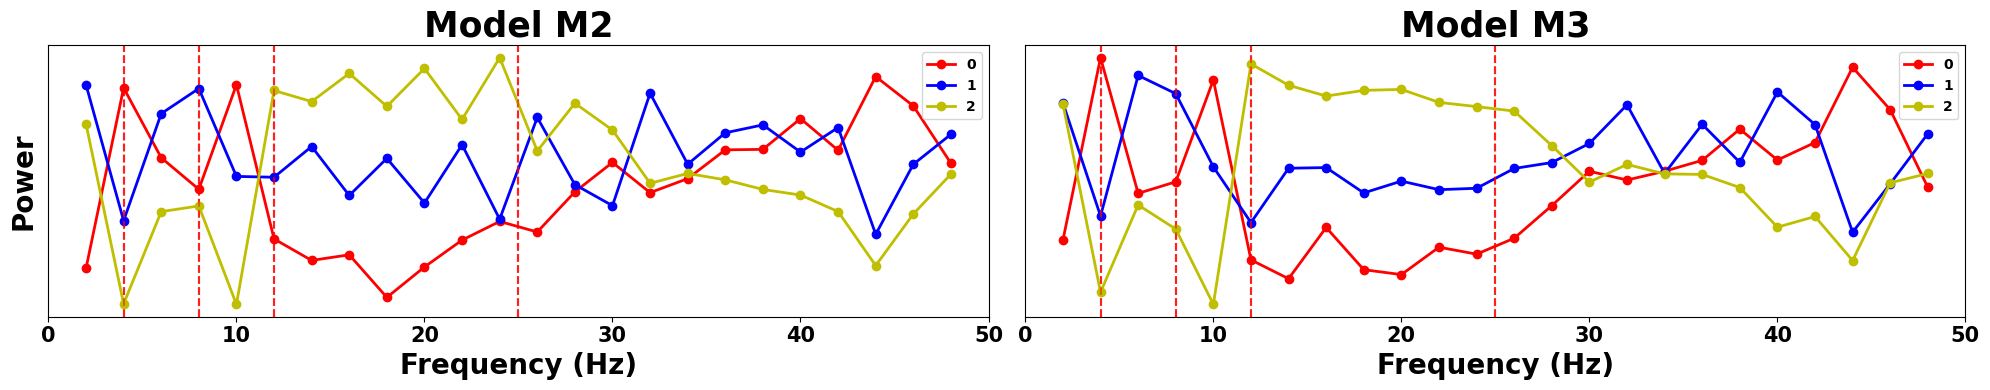

In [11]:
# Plot Cluster Centers
colors = ['r','b','y','g','k','c']
legend_properties = {'weight':'bold'}
names = np.arange(NClusters)
plt.figure(figsize=(20,4))
for idx in np.arange(1,3):
    if idx == 1:
        freq_vals = freq_vals_M2[1:]
        centers = centers_M2
    else:
        freq_vals = freq_vals_M3[1:]
        centers = centers_M3
        
    plt.subplot(1,2,idx)
    for i in range(NClusters):
        plt.plot(freq_vals,centers[i,:],linewidth=2,marker='o',label=str(names[i]),color=colors[i]);
        # Plot Frequency Band Markers
        xvals = (4,8,12,25) # boundaries of frequency bands
        for x in xvals:
              plt.axvline(x=(x),color='r',linestyle='dashed',alpha=0.5)
    plt.legend(prop = legend_properties,loc ="upper right",fontsize=15);
    plt.xlabel('Frequency (Hz)',weight='bold',fontsize=20)
    plt.xticks(weight='bold',fontsize=15)
    plt.xlim([0,50])
    if idx == 1:
        plt.ylabel('Power',weight='bold',fontsize=20);
    plt.yticks([])
    plt.title('Model M' + str(idx+1),weight='bold',fontsize=25)
plt.tight_layout()

# plt.savefig('/home/users/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/ResultsFigures/ClusterCentroids.png')

## M2 - Activation Analysis

In [40]:
def get_Model_M2_activations():
    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))
    
    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    # model = Sequential()

    inputs = Input(shape=(n_timesteps, n_features))
    
    x = tf.transpose(inputs,perm=[0,2,1])
    
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters=20,
                    kernel_size= (50), 
                    strides=(50),
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    outputs = tf.transpose(x,perm=[0,1,3,2])

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return(model)

In [41]:
from scipy.stats import entropy

In [44]:
# GET CLUSTER 
gss = GroupShuffleSplit(n_splits = 50, train_size = 0.9, random_state = 3) # 2

activation_means_M2 = []; activation_tstats_M2 = []; activation_pvals_M2 = [];

fold = 0
for tv_idx, test_idx in gss.split(data, labels, groups):
    
    print('Fold = ' +str(fold))

    # GET TEST SAMPLES
    X_test = data[test_idx,...]
    y_test = labels[test_idx,...]

    # GET MODEL
    clear_session()

    # Get Original Model
    file_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M2v3_kt_fold0"+str(fold)+".hdf5"
    model = get_Model_M2()
    model.load_weights(file_path)

    # Get Model Layers for Activation Analysis
    activation_model = get_Model_M2_activations()
    for layer in range(7):
        weights = model.layers[layer].get_weights()
        activation_model.layers[layer].set_weights(weights)

    # Get Activations
    activations = activation_model.predict(X_test)

    # Normalize Activations

    activations_norm = activations/np.expand_dims(np.sum(activations,axis=(1,2,3)),axis=(1,2,3))

    # Get Mean Activations over Time
    activations_mean_time = np.mean(activations_norm,axis=1)

    # Get Mean Activations within Each Cluster of Filters
    activations_mean_cluster = []
    filter_idx = cluster_labels_M2[fold*n_filters_m2:(fold+1)*n_filters_m2]
    for cluster in range(NClusters):
        activations_cluster = activations_mean_time[:,:,filter_idx==cluster*np.ones_like(filter_idx)]
        activations_mean_cluster.append(np.nanmean(activations_cluster,axis=2))

    # Get Activations for MDDs and HCs
    hc_vals = np.array(activations_mean_cluster)[:,y_test==np.zeros_like(y_test),:]
    mdd_vals = np.array(activations_mean_cluster)[:,y_test==np.ones_like(y_test),:]

    # Get Activation Mean for Each Class and Across Classes
    activation_mean_all = np.nanmean(activations_mean_cluster,axis=1)
    activation_mean_mdd = np.nanmean(mdd_vals,axis=1)
    activation_mean_hc = np.nanmean(hc_vals,axis=1)
    activation_mean = np.stack([activation_mean_all,activation_mean_mdd,activation_mean_hc],axis=2)
    activation_means_M2.append(activation_mean)

    # Get T-test results
    tstat,pval = ttest_ind(hc_vals,mdd_vals,axis=1,nan_policy='omit')

    # Perform FDR Correction
    pval_reshaped = []
    for idx in range(np.shape(pval)[0]):
        pval_reshaped.extend(pval[idx,:])

    pval_corrected_reshaped = fdrcorrection(pval_reshaped)[1]

    pval_corrected = []
    for idx in range(NClusters):
        pval_corrected.append(pval_corrected_reshaped[idx*19:(idx+1)*19])

    activation_tstats_M2.append(tstat); activation_pvals_M2.append(pval_corrected)
    fold += 1

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9
Fold = 10
Fold = 11
Fold = 12
Fold = 13
Fold = 14
Fold = 15
Fold = 16
Fold = 17
Fold = 18
Fold = 19
Fold = 20
Fold = 21
Fold = 22
Fold = 23
Fold = 24
Fold = 25
Fold = 26
Fold = 27


/tmp/ipykernel_456422/2713734979.py:52: RuntimeWarning: Mean of empty slice
  activation_mean_mdd = np.nanmean(mdd_vals,axis=1)


Fold = 28
Fold = 29
Fold = 30
Fold = 31
Fold = 32
Fold = 33
Fold = 34
Fold = 35
Fold = 36
Fold = 37
Fold = 38
Fold = 39
Fold = 40
Fold = 41
Fold = 42
Fold = 43
Fold = 44
Fold = 45
Fold = 46
Fold = 47
Fold = 48
Fold = 49


In [45]:
# Get Number of Significant Negative and Positive Folds
t_stat_positive_M2 = activation_tstats_M2>np.zeros_like(activation_tstats_M2)
t_stat_negative_M2 = activation_tstats_M2<np.zeros_like(activation_tstats_M2)
p_val_significant_M2 = activation_pvals_M2 < 0.05*np.ones_like(activation_tstats_M2)
significant_positive_M2 = np.sum(t_stat_positive_M2 * p_val_significant_M2,axis=0)
significant_negative_M2 = np.sum(t_stat_negative_M2 * p_val_significant_M2,axis=0)

## M3 - Activation Analysis

In [46]:
def get_Model_M3_activations():
    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))
    
    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    # model = Sequential()

    inputs = Input(shape=(n_timesteps, n_features))
    
    x = tf.transpose(inputs,perm=[0,2,1])
    
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters=20,
                    kernel_size= (50), 
                    strides=(50),
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    outputs = tf.transpose(x,perm=[0,1,3,2])

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return(model)

In [47]:
# GET CLUSTER 
gss = GroupShuffleSplit(n_splits = 50, train_size = 0.9, random_state = 3) # 2

activation_means_M3 = []; activation_tstats_M3 = []; activation_pvals_M3 = [];

fold = 0
for tv_idx, test_idx in gss.split(data, labels, groups):
    
    print('Fold = ' +str(fold))

    # GET TEST SAMPLES
    X_test = data[test_idx,...]
    y_test = labels[test_idx,...]

    # GET MODEL
    clear_session()

    # Get Original Model
    file_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M3_XAIWC_kt_fold0"+str(fold)+".hdf5"
    model = get_Model_M3()
    model.load_weights(file_path)

    # Get Model Layers for Activation Analysis
    activation_model = get_Model_M3_activations()
    for layer in range(7):
        weights = model.layers[layer].get_weights()
        activation_model.layers[layer].set_weights(weights)

    # Get Activations
    activations = activation_model.predict(X_test)

    # Normalize Activations

    activations_norm = activations/np.expand_dims(np.sum(activations,axis=(1,2,3)),axis=(1,2,3))

    # Get Mean Activations over Time
    activations_mean_time = np.mean(activations_norm,axis=1)

    # Get Mean Activations within Each Cluster of Filters
    activations_mean_cluster = []
    filter_idx = cluster_labels_M3[fold*n_filters_m3:(fold+1)*n_filters_m3]
    for cluster in range(NClusters):
        activations_cluster = activations_mean_time[:,:,filter_idx==cluster*np.ones_like(filter_idx)]
        activations_mean_cluster.append(np.nanmean(activations_cluster,axis=2))

    # Get Activations for MDDs and HCs
    hc_vals = np.array(activations_mean_cluster)[:,y_test==np.zeros_like(y_test),:]
    mdd_vals = np.array(activations_mean_cluster)[:,y_test==np.ones_like(y_test),:]

    # Get Activation Mean for Each Class and Across Classes
    activation_mean_all = np.nanmean(activations_mean_cluster,axis=1)
    activation_mean_mdd = np.nanmean(mdd_vals,axis=1)
    activation_mean_hc = np.nanmean(hc_vals,axis=1)
    activation_mean = np.stack([activation_mean_all,activation_mean_mdd,activation_mean_hc],axis=2)
    activation_means_M3.append(activation_mean)

    # Get T-test results
    tstat,pval = ttest_ind(hc_vals,mdd_vals,axis=1,nan_policy='omit')

    # Perform FDR Correction
    pval_reshaped = []
    for idx in range(np.shape(pval)[0]):
        pval_reshaped.extend(pval[idx,:])

    pval_corrected_reshaped = fdrcorrection(pval_reshaped)[1]

    pval_corrected = []
    for idx in range(NClusters):
        pval_corrected.append(pval_corrected_reshaped[idx*19:(idx+1)*19])

    activation_tstats_M3.append(tstat); activation_pvals_M3.append(pval_corrected)
    fold += 1

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9
Fold = 10
Fold = 11
Fold = 12
Fold = 13
Fold = 14
Fold = 15
Fold = 16
Fold = 17
Fold = 18
Fold = 19
Fold = 20
Fold = 21
Fold = 22
Fold = 23
Fold = 24
Fold = 25
Fold = 26
Fold = 27


/tmp/ipykernel_456422/3819666191.py:52: RuntimeWarning: Mean of empty slice
  activation_mean_mdd = np.nanmean(mdd_vals,axis=1)


Fold = 28
Fold = 29
Fold = 30
Fold = 31
Fold = 32
Fold = 33
Fold = 34
Fold = 35
Fold = 36
Fold = 37
Fold = 38
Fold = 39
Fold = 40
Fold = 41
Fold = 42
Fold = 43
Fold = 44
Fold = 45
Fold = 46
Fold = 47
Fold = 48
Fold = 49


In [48]:
# Get Number of Significant Negative and Positive Folds
t_stat_positive_M3 = activation_tstats_M3>np.zeros_like(activation_tstats_M3)
t_stat_negative_M3 = activation_tstats_M3<np.zeros_like(activation_tstats_M3)
p_val_significant_M3 = activation_pvals_M3 < 0.05*np.ones_like(activation_tstats_M3)
significant_positive_M3 = np.sum(t_stat_positive_M3 * p_val_significant_M3,axis=0)
significant_negative_M3 = np.sum(t_stat_negative_M3 * p_val_significant_M3,axis=0)

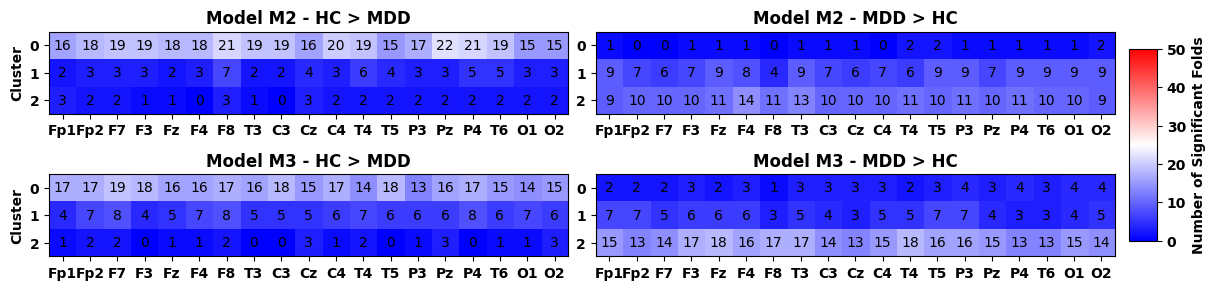

In [56]:
fig = plt.figure(figsize=(14,3))
for mod in np.arange(2):
    if mod == 0:
        significant_positive = significant_positive_M2
        significant_negative = significant_negative_M2
        title_line0 = 'Model M2'
    else:
        significant_positive = significant_positive_M3
        significant_negative = significant_negative_M3
        title_line0 = 'Model M3'

    xtick_vals = [str(i) for i in range(NClusters)]
    title_line1 = ['MDD','HC']
    plt.subplot(2,2,1+(2*mod))
    plt.imshow(significant_positive,'bwr',vmin=0,vmax=50)
    for channel in range(19):
        for cluster in range(NClusters):
            plt.text(channel,cluster,significant_positive[cluster,channel],
                     horizontalalignment='center',verticalalignment='center')
    plt.xticks(np.arange(19),channels,weight='bold')
    plt.yticks(np.arange(NClusters),xtick_vals,weight='bold')
    # plt.colorbar();
    plt.title(title_line0 + ' - HC > MDD',weight='bold')
    plt.ylabel('Cluster',weight='bold')
    plt.subplot(2,2,2+(2*mod))
    im = plt.imshow(significant_negative,'bwr',vmin=0,vmax=50)
    plt.xticks(np.arange(19),channels,weight='bold')
    plt.yticks(np.arange(NClusters),xtick_vals,weight='bold')
    # plt.colorbar();
    plt.title(title_line0 + ' - MDD > HC',weight='bold')
    for channel in range(19):
        for cluster in range(NClusters):
            plt.text(channel,cluster,significant_negative[cluster,channel],
                             horizontalalignment='center',verticalalignment='center')

fig.tight_layout()
fig.subplots_adjust(right=0.8);
cbar_ax = fig.add_axes([0.81,0.18,0.02,0.64])
cbar = fig.colorbar(im,cax=cbar_ax);
cbar.ax.tick_params(labelsize=10);
cbar.set_label(label='Number of Significant Folds', weight='bold')
cbar.ax.set_yticks([0,10,20,30,40,50]);
cbar.ax.set_yticklabels(['0','10','20','30','40','50'],weight='bold');
    
plt.savefig('/home/users/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/ResultsFigures/M2_M3_Activations.png')

## M2 - Correlation Analyses

In [30]:
def get_Model_M2_channel_activations():

    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                    kernel_constraint=max_norm(max_value = 1))

    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    inputs = Input(shape=(n_timesteps, n_features))

    x = tf.transpose(inputs,perm=[0,2,1])

    stride_kernel_size_0 = 50
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters = 20,
                    kernel_size = stride_kernel_size_0, 
                    strides = stride_kernel_size_0,
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    x = tf.transpose(x,perm=[0,1,3,2])
    x = BatchNormalization()(x)

    stride_size_1 = 10
    kernel_size_1 = 10
    x = convLayer2D(filters=1,
                    kernel_size= (kernel_size_1,1), 
                    strides=(stride_size_1,1),
                    data_format='channels_last')(x)
    outputs = tf.squeeze(x,axis=3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = 0.001#hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

In [31]:
# Function for Calculating Correlation Matrix
from scipy.stats import pearsonr
import pandas as pd

def calculate_pearsonr(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    corr_vals = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if c < r:
                tmp = df[df[r].notnull() & df[c].notnull()]
                corr_vals[c][r], pvalues[c][r] = np.round(pearsonr(tmp[r], tmp[c]), 4)
                pvalues[r][c] = pvalues[c][r]
                corr_vals[r][c] = corr_vals[c][r]

    return corr_vals, pvalues

def vec2mat(vec,ROI):
    matrix = np.zeros((ROI,ROI))
    #     matrix = np.chararray((ROI,ROI),itemsize=13) # if string
    count = 0
    for i in np.arange(ROI):
        for j in np.arange(i+1,ROI):
            matrix[i,j] = vec[count]
            matrix[j,i] = vec[count]
            count += 1
    return(matrix)

def mat2vec(mat):
    vec = np.zeros((np.int(((np.shape(mat)[0]*np.shape(mat)[1])-np.shape(mat)[1])/2)))
    
    count = 0
    for i in np.arange(np.shape(mat)[0]):
        for j in np.arange(i+1,np.shape(mat)[1]):
            vec[count] = mat[i,j]
            count += 1
    return(vec)

def mat2vec_3d(mat):
    vec = np.zeros((np.shape(mat)[0],np.int(((np.shape(mat)[1]*np.shape(mat)[2])-np.shape(mat)[1])/2)))
    
    count = 0
    for i in np.arange(np.shape(mat)[1]):
        for j in np.arange(i+1,np.shape(mat)[2]):
            vec[:,count] = mat[:,i,j]
            count += 1
    return(vec)

def vec2mat_3d(vec,ROI):
    matrix = np.nan*np.ones((np.shape(vec)[0],ROI,ROI))
    #     matrix = np.chararray((ROI,ROI),itemsize=13) # if string
    count = 0
    for i in np.arange(ROI):
        for j in np.arange(i+1,ROI):
            matrix[:,i,j] = vec[:,count]
            matrix[:,j,i] = vec[:,count]
            count += 1
    return(matrix)

# Determine Whether Feature has Positive or Negative Significance
def positive_negative_significance(stat,pval):
    positive = stat>np.zeros_like(stat)
    negative = stat<np.zeros_like(stat)
    p_val_significant = pval < 0.05*np.ones_like(pval)
    significant_positive = np.sum(positive * p_val_significant,axis=0)
    significant_negative = np.sum(negative * p_val_significant,axis=0)
    return(significant_positive,significant_negative)

def rearrange_corrmat(corrmat,new_order,ROI):
    new_corrmat = np.zeros((ROI,ROI))
    for i in np.arange(ROI):
        for j in np.arange(ROI):
            new_corrmat[i,j] = corrmat[new_order[i],new_order[j]]
    return(new_corrmat)

In [82]:
# GET CLUSTER 
gss = GroupShuffleSplit(n_splits = 50, train_size = 0.9, random_state = 3) # 2

corr_hc = []; corr_mdd = []; 
corr_tstat_m2 = []; corr_pval_m2 = [];

i = 0
for tv_idx, test_idx in gss.split(data, labels, groups):
    
    print('Fold = ' +str(i))

    # GET TEST SAMPLES
    X_test = data[test_idx,...]
    y_test = labels[test_idx,...]

    # GET MODEL
    clear_session()

    # Get Original Model
    file_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M2v3_kt_fold0"+str(i)+".hdf5"
    model = get_Model_M2()
    model.load_weights(file_path)

    # Get Model Layers for Activation Analysis
    activation_model = get_Model_M2_channel_activations()
    for layer in range(11):
        weights = model.layers[layer].get_weights()
        activation_model.layers[layer].set_weights(weights)

    # Get Activations
    activations = activation_model.predict(X_test)

    # Normalize Activations
    activations_norm = activations/np.expand_dims(np.sum(activations,axis=1),axis=(1))
    
    # Get Correlations Between Activations Over Time
    corr = [];
    for sample in range(np.shape(activations)[0]):
        corr_val = pd.DataFrame(activations[sample,...]).corr()
        corr.append(corr_val);
    corr_reshaped = mat2vec_3d(np.array(corr))
    
    # Get Correlations for HCs and MDDs
    hc_vals = np.array(corr_reshaped)[y_test==np.zeros_like(y_test),:]
    mdd_vals = np.array(corr_reshaped)[y_test==np.ones_like(y_test),:]
    corr_hc.append(vec2mat(np.mean(hc_vals,axis=0),19))
    corr_mdd.append(vec2mat(np.mean(mdd_vals,axis=0),19))

    # Compare Correlations between HCs and MDDs
    tstat,pval = ttest_ind(hc_vals,mdd_vals,axis=0)
    corr_tstat_m2.append(vec2mat(tstat,19))
    
    # Apply FDR Correction
    corr_pval_m2.append(vec2mat(fdrcorrection(pval)[1],19))
    
    i += 1

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9
Fold = 10
Fold = 11
Fold = 12
Fold = 13
Fold = 14
Fold = 15
Fold = 16
Fold = 17
Fold = 18
Fold = 19
Fold = 20
Fold = 21
Fold = 22
Fold = 23
Fold = 24
Fold = 25
Fold = 26
Fold = 27


/home/users/cellis42/anaconda3/envs/AutoML_n/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/cellis42/anaconda3/envs/AutoML_n/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Fold = 28
Fold = 29
Fold = 30
Fold = 31
Fold = 32
Fold = 33
Fold = 34
Fold = 35
Fold = 36
Fold = 37
Fold = 38
Fold = 39
Fold = 40
Fold = 41
Fold = 42
Fold = 43
Fold = 44
Fold = 45
Fold = 46
Fold = 47
Fold = 48
Fold = 49


In [83]:
save_path = '/data/users3/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/corr_results_m2.mat'
savemat(save_path,{'corr_tstat':corr_tstat_m2,'corr_pval':corr_pval_m2,'corr_hc':corr_hc,'corr_mdd':corr_mdd})

In [84]:
save_path = '/data/users3/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/corr_results_m2.mat'

corr_tstat_m2 = loadmat(save_path)['corr_tstat']
corr_pval_m2 = loadmat(save_path)['corr_pval']

In [105]:
# Determine Whether Feature has Positive or Negative Significance
threshold_of_significance = 25
significant_positive_m2, significant_negative_m2 = positive_negative_significance(corr_tstat_m2,corr_pval_m2)
pos_less_than_25 = significant_positive_m2<threshold_of_significance*np.ones_like(significant_positive_m2)
neg_less_than_25 = significant_negative_m2<threshold_of_significance*np.ones_like(significant_negative_m2)
significant_positive_m2[pos_less_than_25] = np.nan * np.ones_like(significant_positive_m2[pos_less_than_25])
significant_negative_m2[neg_less_than_25] = np.nan * np.ones_like(significant_negative_m2[neg_less_than_25])

# Get New Order of Channels
new_order_of_channels = [0,1,2,3,4,5,6,7,11,12,16,8,9,10,13,14,15,17,18]

# Re-Order Correlation Matrix to Separate Based on Channel
significant_positive_rearrange_m2 = rearrange_corrmat(significant_positive_m2,new_order_of_channels,19)
significant_negative_rearrange_m2 = rearrange_corrmat(significant_negative_m2,new_order_of_channels,19)

## M3 - Correlation Analyis

In [38]:
def get_Model_M3_channel_activations():

    n_timesteps = 3000
    n_features = 19

    convLayer2D = partial(Conv2D,activation='elu',kernel_initializer='he_normal',padding='valid',
                    kernel_constraint=max_norm(max_value = 1))

    convLayer1D = partial(Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
                        kernel_constraint=max_norm(max_value = 1))

    inputs = Input(shape=(n_timesteps, n_features))

    x = tf.transpose(inputs,perm=[0,2,1])

    stride_kernel_size_0 = 50
    x = tf.keras.layers.Reshape((int(n_timesteps*n_features),1))(x)
    x = convLayer1D(filters = 20,
                    kernel_size = stride_kernel_size_0, 
                    strides = stride_kernel_size_0,
                    data_format='channels_last')(x)

    x = tf.expand_dims(x,axis=3)
    x_shape = x.shape
    x = tf.split(x,19,1)
    x = tf.keras.layers.Concatenate(axis=3)(x)
    x = tf.transpose(x,perm=[0,1,3,2])
    x = BatchNormalization()(x)

    stride_size_1 = 10
    kernel_size_1 = 5
    x = convLayer2D(filters=1,
                    kernel_size= (kernel_size_1,1), 
                    strides=(stride_size_1,1),
                    data_format='channels_last')(x)
    outputs = tf.squeeze(x,axis=3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = 0.001#hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                     metrics = ['acc'])

    return model

In [86]:
# GET CLUSTER 
gss = GroupShuffleSplit(n_splits = 50, train_size = 0.9, random_state = 3) # 2

corr_hc = []; corr_mdd = []; 
corr_tstat_m3 = []; corr_pval_m3 = [];

i = 0
for tv_idx, test_idx in gss.split(data, labels, groups):
    
    print('Fold = ' +str(i))

    # GET TEST SAMPLES
    X_test = data[test_idx,...]
    y_test = labels[test_idx,...]

    # GET MODEL
    clear_session()

    # Get Original Model
    file_path = "/data/users3/cellis42/Spectral_Explainability/InterpretableConv/model_M3_XAIWC_kt_fold0"+str(i)+".hdf5"
    model = get_Model_M3()
    model.load_weights(file_path)

    # Get Model Layers for Activation Analysis
    activation_model = get_Model_M3_channel_activations()
    for layer in range(11):
        weights = model.layers[layer].get_weights()
        activation_model.layers[layer].set_weights(weights)

    # Get Activations
    activations = activation_model.predict(X_test)

    # Normalize Activations
    activations_norm = activations/np.expand_dims(np.sum(activations,axis=1),axis=(1))
    
    # Get Correlations Between Activations Over Time
    corr = [];
    for sample in range(np.shape(activations)[0]):
        corr_val = pd.DataFrame(activations[sample,...]).corr()
        corr.append(corr_val);
    corr_reshaped = mat2vec_3d(np.array(corr))
    
    # Get Correlations for HCs and MDDs
    hc_vals = np.array(corr_reshaped)[y_test==np.zeros_like(y_test),:]
    mdd_vals = np.array(corr_reshaped)[y_test==np.ones_like(y_test),:]
    corr_hc.append(vec2mat(np.mean(hc_vals,axis=0),19))
    corr_mdd.append(vec2mat(np.mean(mdd_vals,axis=0),19))

    # Compare Correlations between HCs and MDDs
    tstat,pval = ttest_ind(hc_vals,mdd_vals,axis=0)
    corr_tstat_m3.append(vec2mat(tstat,19))
    
    # Apply FDR Correction
    corr_pval_m3.append(vec2mat(fdrcorrection(pval)[1],19))
    
    i += 1

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9
Fold = 10
Fold = 11
Fold = 12
Fold = 13
Fold = 14
Fold = 15
Fold = 16
Fold = 17
Fold = 18
Fold = 19
Fold = 20
Fold = 21
Fold = 22
Fold = 23
Fold = 24
Fold = 25
Fold = 26
Fold = 27


/home/users/cellis42/anaconda3/envs/AutoML_n/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/cellis42/anaconda3/envs/AutoML_n/lib/python3.9/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Fold = 28
Fold = 29
Fold = 30
Fold = 31
Fold = 32
Fold = 33
Fold = 34
Fold = 35
Fold = 36
Fold = 37
Fold = 38
Fold = 39
Fold = 40
Fold = 41
Fold = 42
Fold = 43
Fold = 44
Fold = 45
Fold = 46
Fold = 47
Fold = 48
Fold = 49


In [87]:
save_path = '/data/users3/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/corr_results_m3.mat'
savemat(save_path,{'corr_tstat':corr_tstat_m3,'corr_pval':corr_pval_m3,'corr_hc':corr_hc,'corr_mdd':corr_mdd})

In [88]:
save_path = '/data/users3/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/corr_results_m3.mat'

corr_tstat_m3 = loadmat(save_path)['corr_tstat']
corr_pval_m3 = loadmat(save_path)['corr_pval']

In [106]:
# Determine Whether Feature has Positive or Negative Significance
significant_positive_m3, significant_negative_m3 = positive_negative_significance(corr_tstat_m3,corr_pval_m3)
pos_less_than_25 = significant_positive_m3<threshold_of_significance*np.ones_like(significant_positive_m3)
neg_less_than_25 = significant_negative_m3<threshold_of_significance*np.ones_like(significant_negative_m3)
significant_positive_m3[pos_less_than_25] = np.nan * np.ones_like(significant_positive_m3[pos_less_than_25])
significant_negative_m3[neg_less_than_25] = np.nan * np.ones_like(significant_negative_m3[neg_less_than_25])

# Re-Order Correlation Matrices and Separate Based on Channel Groups
significant_positive_rearrange_m3 = rearrange_corrmat(significant_positive_m3,new_order_of_channels,19)
significant_negative_rearrange_m3 = rearrange_corrmat(significant_negative_m3,new_order_of_channels,19)

/tmp/ipykernel_1556902/297124042.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


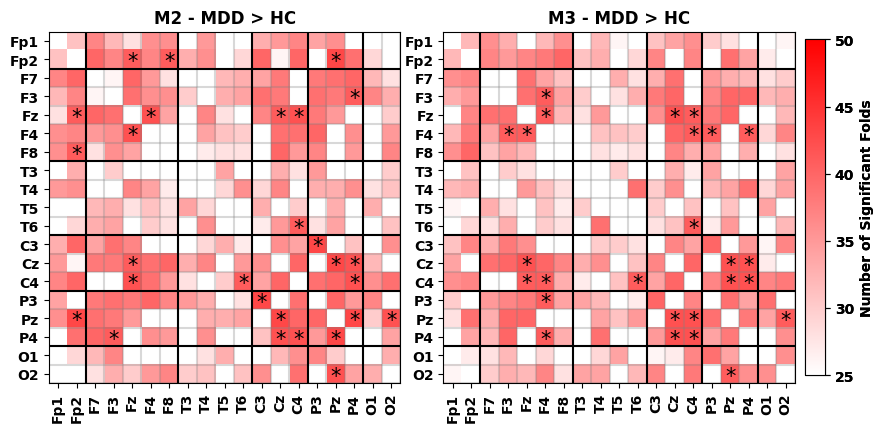

In [134]:
my_cmap = LinearSegmentedColormap.from_list("", ["white","red"])
boundaries = [1.5,6.5,10.5,13.5,16.5]
small_boundaries = ((np.arange(1,19)-0.5))+1
tick_locs = np.arange(19)

fig = plt.figure(figsize=(10,8))
ax = np.zeros_like(np.arange(4));
for mod in np.arange(2):
    if mod == 0:
        significant_negative = significant_negative_rearrange_m2
        title = 'M2'
    else:
        significant_negative = significant_negative_rearrange_m3
        title = 'M3'
    
    ax1 = plt.subplot(1,2,mod+1)
    ax1.imshow(significant_negative,vmin=25,vmax=50,cmap=my_cmap)
    for bound in list(small_boundaries):
        ax1.axvline(bound,ymin=-0.5,ymax=18.5,color='gray',linestyle='-',alpha=0.3)
        ax1.axhline(bound,xmin=-0.5,xmax=18.5,color='gray',linestyle='-',alpha=0.3)
    for bound in list(boundaries):
        ax1.axvline(bound,ymin=-0.5,ymax=18.5,color='k',linestyle='-')
        ax1.axhline(bound,xmin=-0.5,xmax=18.5,color='k',linestyle='-')
    ax1.set_xlim([-0.5,18.5])
    ax1.set_ylim([-0.5,18.5])
    ax1.set_title(title + ' - MDD > HC',weight='bold')
    ax1.set_xticks(tick_locs)
    ax1.set_xticklabels(np.array(channels)[new_order_of_channels], rotation='vertical',weight='bold')
    ax1.set_yticks(tick_locs)
    ax1.set_yticklabels(np.array(channels)[new_order_of_channels],weight='bold')
    ax1.invert_yaxis()
    for channel1 in np.arange(19):
        for channel2 in np.arange(19):
            if significant_negative[channel1,channel2] > 40:
                plt.text(channel1,channel2+0.13,'*',horizontalalignment='center',verticalalignment='center',fontsize=15)

    fig.tight_layout()
    fig.subplots_adjust(right=0.8);
    cbar_ax1 = fig.add_axes([0.81,0.29,0.02,0.42])
    cbar1 = fig.colorbar(im,cax=cbar_ax1);
    cbar1.ax.tick_params(labelsize=10);
    cbar1.ax.set_yticks([25,30,35,40,45,50])
    cbar1.ax.set_yticklabels(['25','30','35','40','45','50'],weight='bold')
    cbar1.set_label(label='Number of Significant Folds', weight='bold')

plt.savefig('/home/users/cellis42/Spectral_Explainability/InterpretableConv/XAIWC2024/ResultsFigures/M2_M3_Correlations_most_important.png')